# Data exploration notebook for text2image retrieval

In [16]:
import os
import sys
import hashlib
import pandas as pd
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import requests
from io import BytesIO
from urllib.parse import urlparse


## 1. Load Data

In [2]:
df = pd.read_csv('../data/images.tsv', sep='\t')

In [29]:
df.head()

,image_urls,image_id,img_file,is_valid_image
0,https://c6.staticflickr.com/3/2808/10351094034...,1762125,10351094034_f3aa58c5d9_o.jpg,False
1,https://c2.staticflickr.com/9/8089/8416776003_...,9059623,8416776003_9f2636ca56_o.jpg,False
2,https://farm3.staticflickr.com/568/21452126474...,2306438,21452126474_ab12789b36_o.jpg,False
3,https://farm4.staticflickr.com/1244/677743874_...,6571968,677743874_90faf2d8db_o.jpg,False
4,https://c3.staticflickr.com/4/3750/9031823026_...,983539,9031823026_48ebe4d436_o.jpg,False


## Note : No column names, let's assign column name to dataframe for better use

- First column : image urls
- second column : image ids
- third column : string, could be base64/ascii encoded string. We can rename this column later

In [4]:
# List of column names to use
column_names = ['image_urls', 'image_id', 'enc_string']
# Assigning new column names to the DataFrame
df.columns = column_names

df.head(5)

,image_urls,image_id,enc_string
0,https://c6.staticflickr.com/3/2808/10351094034...,1762125,38x6O2LAS75H1vUGVzIilg==
1,https://c2.staticflickr.com/9/8089/8416776003_...,9059623,4ksF8TuGWGcKul6Z/6pq8g==
2,https://farm3.staticflickr.com/568/21452126474...,2306438,R+6Cs525mCUT6RovHPWREg==
3,https://farm4.staticflickr.com/1244/677743874_...,6571968,JnkYas7iDJu+pb81tfqVow==
4,https://c3.staticflickr.com/4/3750/9031823026_...,983539,fZrDEkI36GRM44ub5xnSOQ==


## Data Exploration

### Descriptive statistics for numerical data

In [5]:
df.describe(include='all').fillna('')

,image_urls,image_id,enc_string
count,41619,41619.0,41619
unique,41619,,41619
top,https://c6.staticflickr.com/3/2808/10351094034...,,38x6O2LAS75H1vUGVzIilg==
freq,1,,1
mean,,2000559.518441,
std,,2448800.962273,
min,,5106.0,
25%,,254684.5,
50%,,1059655.0,
75%,,2826917.5,


### Frequency of unique values in 'image_id'

In [6]:
df['image_id'].value_counts()

image_id
130255     3
105734     3
213475     3
4933606    3
58612      3
          ..
698832     1
3040320    1
536051     1
97304      1
2789066    1
Name: count, Length: 41266, dtype: int64

### Check for missing values in each column

In [7]:
df.isnull().sum()

image_urls    0
image_id      0
enc_string    0
dtype: int64

Note : No missing data, so do not need to impute any missing values

## Let's analyze what is the enc_string column

In [8]:
# Checking the first few values of enc_string
df['enc_string'][0]

'38x6O2LAS75H1vUGVzIilg=='

In [9]:
df['enc_string'].apply(lambda x: len(x)).unique()

array([24])

In [10]:
# Check uniformity in length which is common in encoded or hashed strings
print(df['enc_string'].apply(len).unique())

[24]


In [11]:
import base64

def try_base64_decode(s):
    try:
        # Ensure string length is a multiple of 4
        s += '=' * (-len(s) % 4)
        return base64.b64decode(s).decode('utf-8')
    except Exception:
        return None

# Test Base64 decoding
df['decoded_base64'] = df['enc_string'].apply(try_base64_decode)
df['decoded_base64']


0        None
1        None
2        None
3        None
4        None
         ... 
41614    None
41615    None
41616    None
41617    None
41618    None
Name: decoded_base64, Length: 41619, dtype: object

In [12]:
def try_hex_decode(s):
    try:
        bytes_obj = bytes.fromhex(s)
        return bytes_obj.decode('utf-8')  # Attempt to decode as UTF-8 or use 'ascii'
    except ValueError:
        return None

# Test Hexadecimal decoding
df['decoded_hex'] = df['enc_string'].apply(try_hex_decode)
print(df['decoded_hex'])


0        None
1        None
2        None
3        None
4        None
         ... 
41614    None
41615    None
41616    None
41617    None
41618    None
Name: decoded_hex, Length: 41619, dtype: object


### Note : 

Since decoding enc_string as either Base64 or hexadecimal have resulted in None for all entries, \
it indicates that these strings are likely not encoded in these formats, \
or they could be encoded in a way that includes non-text data that does not translate into readable UTF-8 or ASCII text. 

## Calculate entropy of enc_string values to gauge their randomness

Higher entropy often indicates cryptographic strength or a high degree of randomness,
suggesting encryption or complex encoding.

In [13]:
import numpy as np
from collections import Counter

def calculate_entropy(string):
    """Calculate the entropy of a given string"""
    p, lns = Counter(string), float(len(string))
    return -sum(count/lns * np.log2(count/lns) for count in p.values())

df['entropy'] = df['enc_string'].apply(calculate_entropy)
print(df['entropy'].describe())


count    41619.000000
mean         4.220318
std          0.132297
min          3.438722
25%          4.136842
50%          4.251629
75%          4.334963
max          4.501629
Name: entropy, dtype: float64


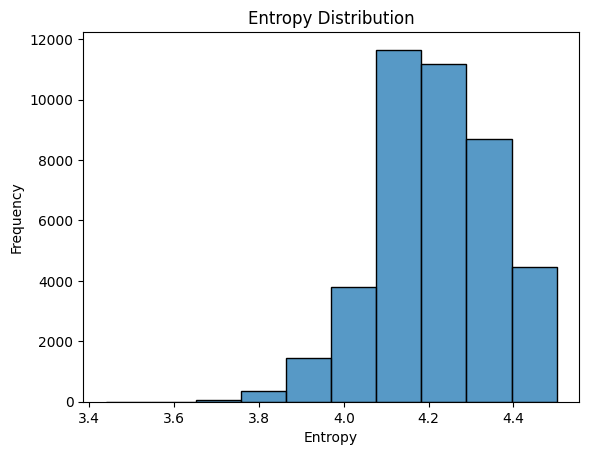

In [14]:
import seaborn as sns

# Plot histogram of entropy values
sns.histplot(df['entropy'], bins=10)
plt.title('Entropy Distribution')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.show()


### Note : 

Entropy in is a measure of the randomness or unpredictability in data. 
It's often used to assess the strength of cryptographic systems, where higher entropy generally means greater security or complexity. Entropy is measured in bits:

- Low Entropy: Indicates predictability and low randomness. For example, a string composed of repetitive or highly regular characters has low entropy.
- High Entropy: Indicates high randomness and unpredictability. This is typical for encrypted data or good cryptographic keys.

An entropy value of 4.0 suggests that the strings have moderate randomness but are not maximally random, especially when compared to potential maximums in cryptographic contexts where you'd expect values closer to 6 or 7 bits per character if the strings were fully random and encrypted.

## Note : I plan to ignore this column for now, as it is not possible to make sense of it

## Extract domain as a new feature


In [17]:
df['domain'] = df['image_urls'].apply(lambda url: urlparse(url).netloc)
df.head()

,image_urls,image_id,enc_string,decoded_base64,decoded_hex,entropy,domain
0,https://c6.staticflickr.com/3/2808/10351094034...,1762125,38x6O2LAS75H1vUGVzIilg==,None,None,4.501629,c6.staticflickr.com
1,https://c2.staticflickr.com/9/8089/8416776003_...,9059623,4ksF8TuGWGcKul6Z/6pq8g==,None,None,4.168296,c2.staticflickr.com
2,https://farm3.staticflickr.com/568/21452126474...,2306438,R+6Cs525mCUT6RovHPWREg==,None,None,4.053509,farm3.staticflickr.com
3,https://farm4.staticflickr.com/1244/677743874_...,6571968,JnkYas7iDJu+pb81tfqVow==,None,None,4.418296,farm4.staticflickr.com
4,https://c3.staticflickr.com/4/3750/9031823026_...,983539,fZrDEkI36GRM44ub5xnSOQ==,None,None,4.418296,c3.staticflickr.com


## Plots : 

- 1. frequency of image_ids if relevant (usually more useful for categorical variables)

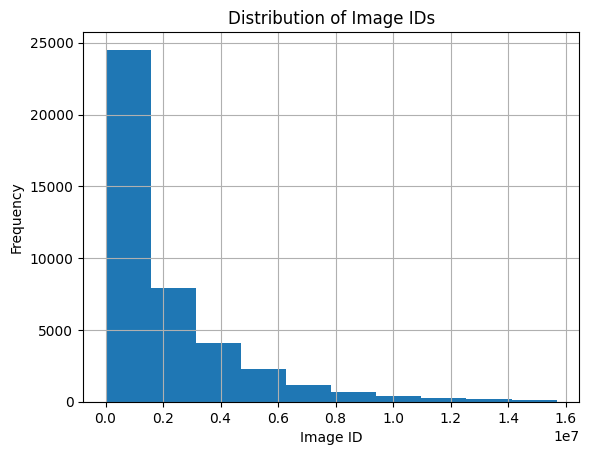

In [18]:
# Histogram to visualize distribution of image_id
df['image_id'].hist()
plt.title('Distribution of Image IDs')
plt.xlabel('Image ID')
plt.ylabel('Frequency')
plt.show()

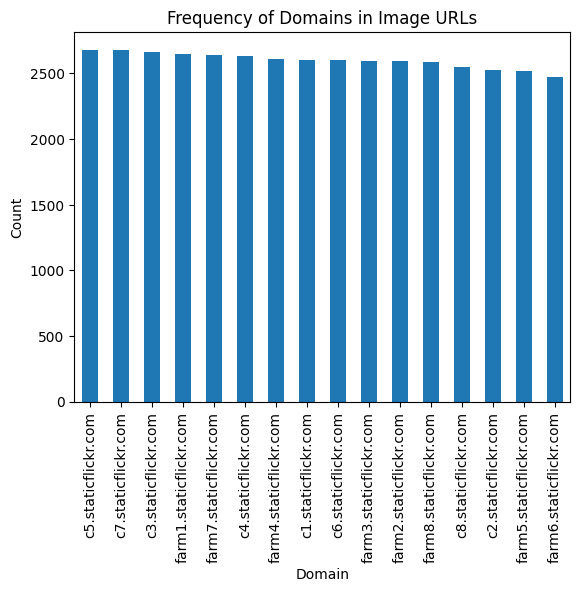

In [19]:
# Frequency of domains
df['domain'].value_counts().plot(kind='bar')
plt.title('Frequency of Domains in Image URLs')
plt.xlabel('Domain')
plt.ylabel('Count')
plt.show()


## Filter image_urls and image_id columns for the search

In [32]:
df.columns

Index(['image_urls', 'image_id', 'img_file', 'is_valid_image'], dtype='object')

In [33]:
df = df[['image_urls','image_id','img_file']]
df.head()

,image_urls,image_id,img_file
0,https://c6.staticflickr.com/3/2808/10351094034...,1762125,10351094034_f3aa58c5d9_o.jpg
1,https://c2.staticflickr.com/9/8089/8416776003_...,9059623,8416776003_9f2636ca56_o.jpg
2,https://farm3.staticflickr.com/568/21452126474...,2306438,21452126474_ab12789b36_o.jpg
3,https://farm4.staticflickr.com/1244/677743874_...,6571968,677743874_90faf2d8db_o.jpg
4,https://c3.staticflickr.com/4/3750/9031823026_...,983539,9031823026_48ebe4d436_o.jpg


## Clean up images

- Download the images in a local folder - using command 'python download_images.py'
- Check for valid path of image and valid images
- Remove the invalid images form the dataframe


In [34]:
df["img_file"] = df['image_urls'].apply(lambda x : os.path.basename(x))

/tmp/ipykernel_187313/1634692008.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["img_file"] = df['image_urls'].apply(lambda x : os.path.basename(x))


In [35]:
df.head()

,image_urls,image_id,img_file
0,https://c6.staticflickr.com/3/2808/10351094034...,1762125,10351094034_f3aa58c5d9_o.jpg
1,https://c2.staticflickr.com/9/8089/8416776003_...,9059623,8416776003_9f2636ca56_o.jpg
2,https://farm3.staticflickr.com/568/21452126474...,2306438,21452126474_ab12789b36_o.jpg
3,https://farm4.staticflickr.com/1244/677743874_...,6571968,677743874_90faf2d8db_o.jpg
4,https://c3.staticflickr.com/4/3750/9031823026_...,983539,9031823026_48ebe4d436_o.jpg


In [40]:
pandarallel.initialize(nb_workers=10, progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [41]:
data_root = '../images'

In [42]:
df['is_valid_image'] = df["img_file"].parallel_apply(
    lambda x: os.path.isfile(os.path.join(data_root, x))
)

In [46]:
len(df[ df["is_valid_image"] == False])

28570

### delete the rows with invalid images

In [48]:
df = df[df["is_valid_image"] == True]

In [49]:
df.describe(include='all').fillna('')

,image_urls,image_id,img_file,is_valid_image
count,13049,13049.0,13049,13049
unique,13049,,13049,1
top,https://c6.staticflickr.com/3/2808/10351094034...,,10351094034_f3aa58c5d9_o.jpg,True
freq,1,,1,13049
mean,,1978990.149743,,
std,,2420189.902484,,
min,,5287.0,,
25%,,259432.0,,
50%,,1033390.0,,
75%,,2796040.0,,


In [52]:
del df["is_valid_image"]

In [53]:
df.columns

Index(['image_urls', 'image_id', 'img_file'], dtype='object')

## Plot Images

In [55]:
from PIL import Image
import matplotlib.pyplot as plt

def plot_images_from_path(path, ax, title=None):
    try:
        # Open the image directly from the path
        image = Image.open(path)
        ax.imshow(image)
        ax.axis('off')  # Disable axis
        if title:
            ax.set_title(title)
    except Exception as e:
        print(f"Failed to load image from {path}: {e}")
        ax.imshow(Image.new('RGB', (128, 128), 'gray'))  # Display a gray placeholder if image fails to load
        ax.set_title("Failed to load")
        ax.axis('off')


In [61]:
def plot_random_images(dataframe, rows=5, cols=5):
    # Adjust the number of images based on rows*cols
    num_images = rows * cols

    # Randomly sample rows from the DataFrame
    sampled_df = dataframe.sample(n=num_images, replace=False) if len(dataframe) >= num_images else dataframe.sample(n=num_images, replace=True)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))
    axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

    for ax, (_, row) in zip(axes, sampled_df.iterrows()):
        plot_images_from_path(os.path.join(data_root, row['img_file']), ax, title=str(row['image_id']))

    plt.tight_layout()
    plt.show()

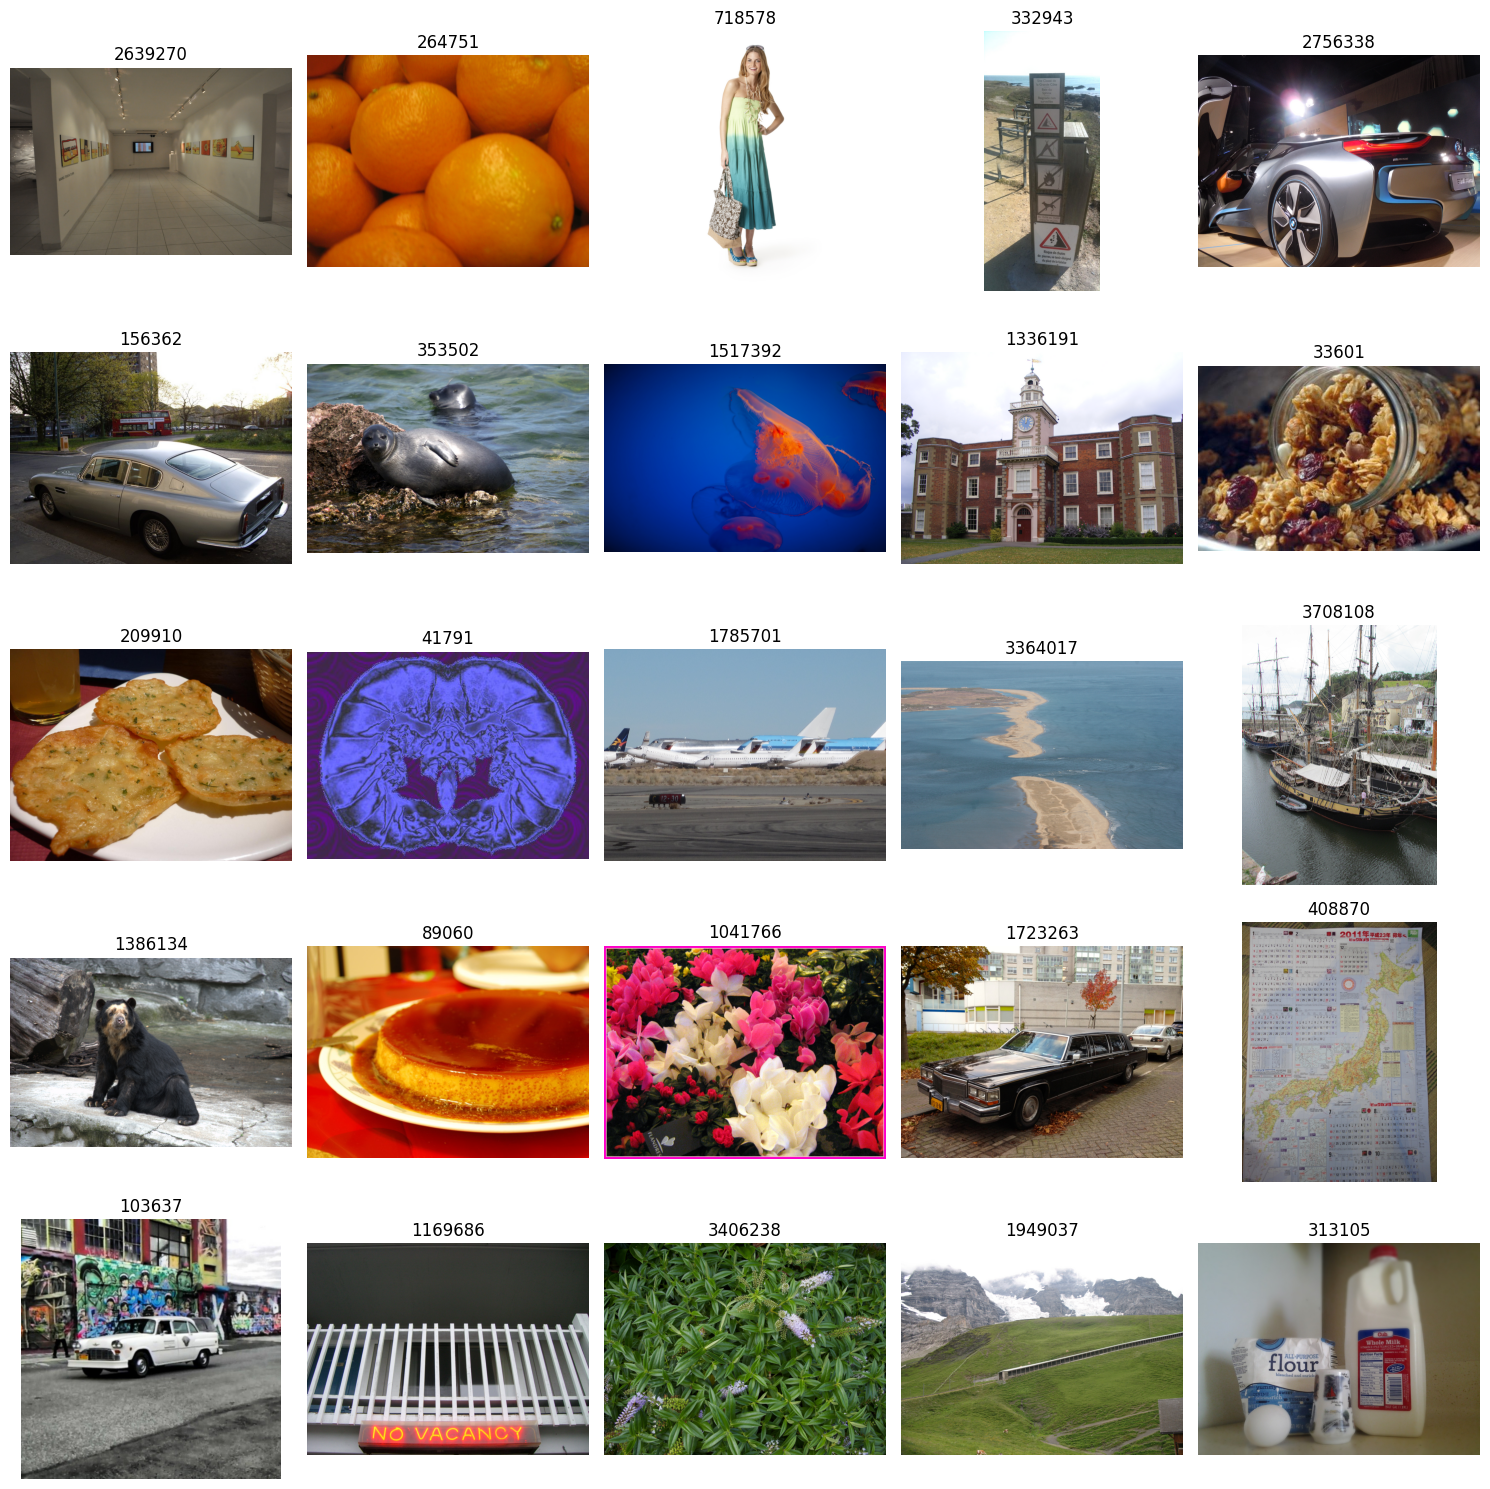

In [63]:
plot_random_images(df)

## Write df to csv

In [64]:
df.to_csv('../data/images.csv', index=False)